# Make sure that experiment predictions are the same


In [24]:
import numpy as np
from miann.data import MPPData
import os
import tqdm
from miann.constants import EXPERIMENT_DIR
import scanpy as sc
import matplotlib.pyplot as plt

In [40]:
results_old = '/home/icb/hannah.spitzer/projects/pelkmans/local_experiments/2021-04-27_VAE_all/CondVAE_pert-CC2'
dataset_old = '/home/icb/hannah.spitzer/projects/pelkmans/local_data/NascentRNA/datasets/184A1_all_frac0005_neigh3_cond_pert-CC'

results_new = 'VAE_all/CondVAE_pert-CC/results_epoch025/val'

mpp_data = MPPData.from_data_dir(data_dir=results_new, base_dir=EXPERIMENT_DIR)
adata = sc.read(os.path.join(results_old, 'adata_epoch025_val.h5ad'))

In [16]:
# check that have same mapobject_ids
(np.unique(adata.obs['mapobject_id']) == np.unique(mpp_data.obj_ids)).all()

True

In [76]:
# check that have same content (but ordering is different due to different implementation of subsampling per object frac)
obj_ids = np.unique(mpp_data.obj_ids)
for obj_id in tqdm.tqdm(obj_ids):
    mask_old = np.array(adata.obs['mapobject_id'] == obj_id)
    mask = mpp_data.obj_ids == obj_id
    # check that have same length
    assert len(mask_old.nonzero()[0]) == len(mask.nonzero()[0])
    # check that values of one channel are the same (ordering is different)
    ch_id = np.random.choice(range(34))
    vals_old = adata.X[mask_old][:,ch_id]
    vals_new = mpp_data.center_mpp[mask][:,ch_id]
    assert set(vals_old) == set(vals_new)
    
    # check that values of latent space are the same
    # are only the same with tolerance of 0.05 - is this due to numerical instability? 
    # I think yes, as I have seen this before, when predicting the same data on the same model
    ch_id = np.random.choice(range(16))
    latent_old = adata.obsm['X_latent'][mask_old][:,ch_id]
    latent_new = mpp_data.data('latent')[mask][:,ch_id]
    assert (np.isclose(sorted(latent_old), sorted(latent_new), atol=0.05)).all()


100%|██████████| 1181/1181 [00:00<00:00, 1197.84it/s]


cannot compare images, because have different obj_ids chosen. This is becaues used np.random.choice in older code, and now use np.random.default_rng().choice

In [49]:
# look at images
img_old = np.load(os.path.join(results_old, 'pred_imgs_epoch025_val.npy'))
# also need old ds to get mapobject ids
ds_old = np.load(os.path.join(dataset_old, f'val_imgs.npz'))
img_new = MPPData.from_data_dir(results_new+'_imgs', base_dir=EXPERIMENT_DIR, optional_keys=['decoder'])

In [66]:
import pandas as pd
obj_ids_old = pd.read_csv(os.path.join(results_old, 'img_ids_val.csv'), header=None)
obj_ids_old = list(obj_ids_old[0].astype(int))

In [69]:
ds_old['mapobject_id'][obj_ids_old]

array([372811, 255443, 368196, 311499, 214922, 279440, 216662, 375096,
       276554, 220668, 350075, 321072, 292313, 376735, 313694, 280498,
       329184, 249355, 208019, 359372, 210691, 251037, 312351, 379761,
       228479])

In [64]:
img_new.unique_obj_ids

array([210685, 210707, 211304, 216972, 228504, 232430, 273005, 286156,
       287441, 291621, 300407, 303066, 304817, 324847, 332646, 336436,
       337404, 343014, 343851, 347293, 347389, 351613, 352396, 371513,
       379368], dtype=uint32)

## Look at evaluation images
- mse is very similar. Good!

In [78]:
from IPython.display import Image

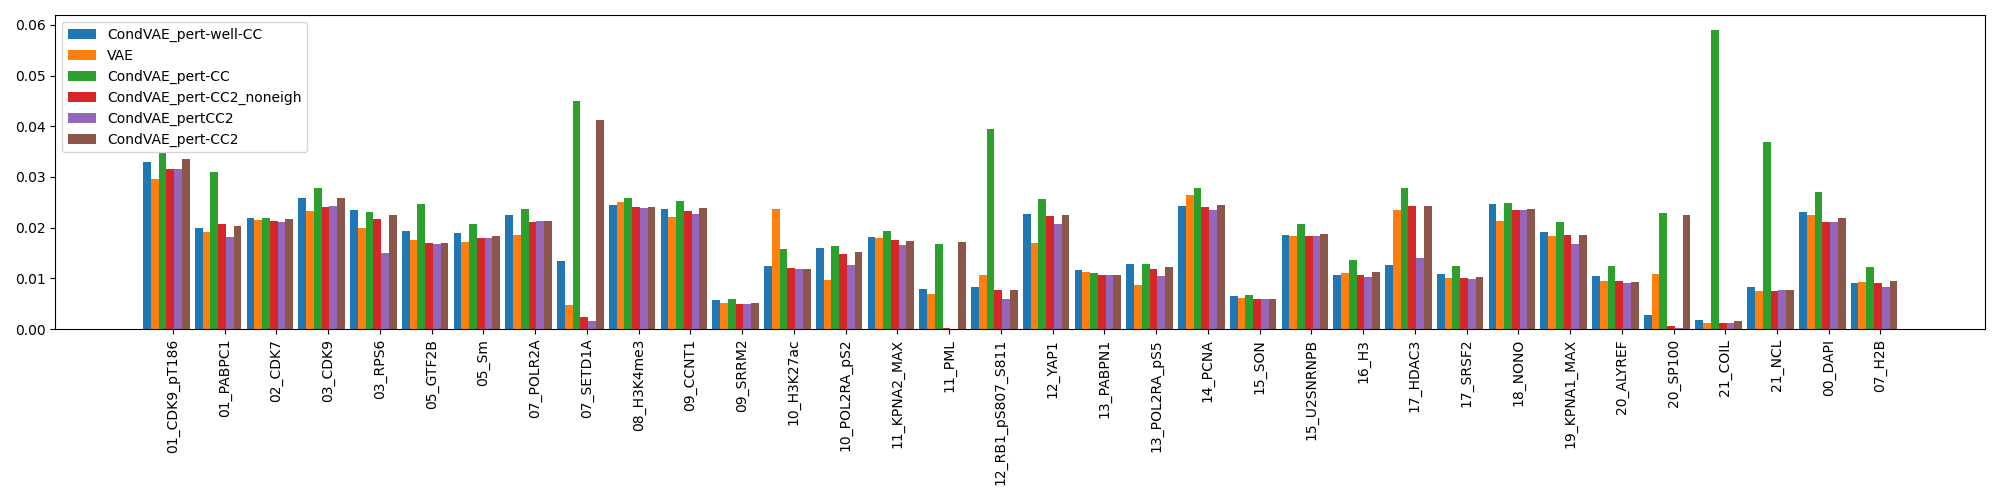

In [79]:
Image(os.path.join(results_old, '../per_channel_mse.png'))

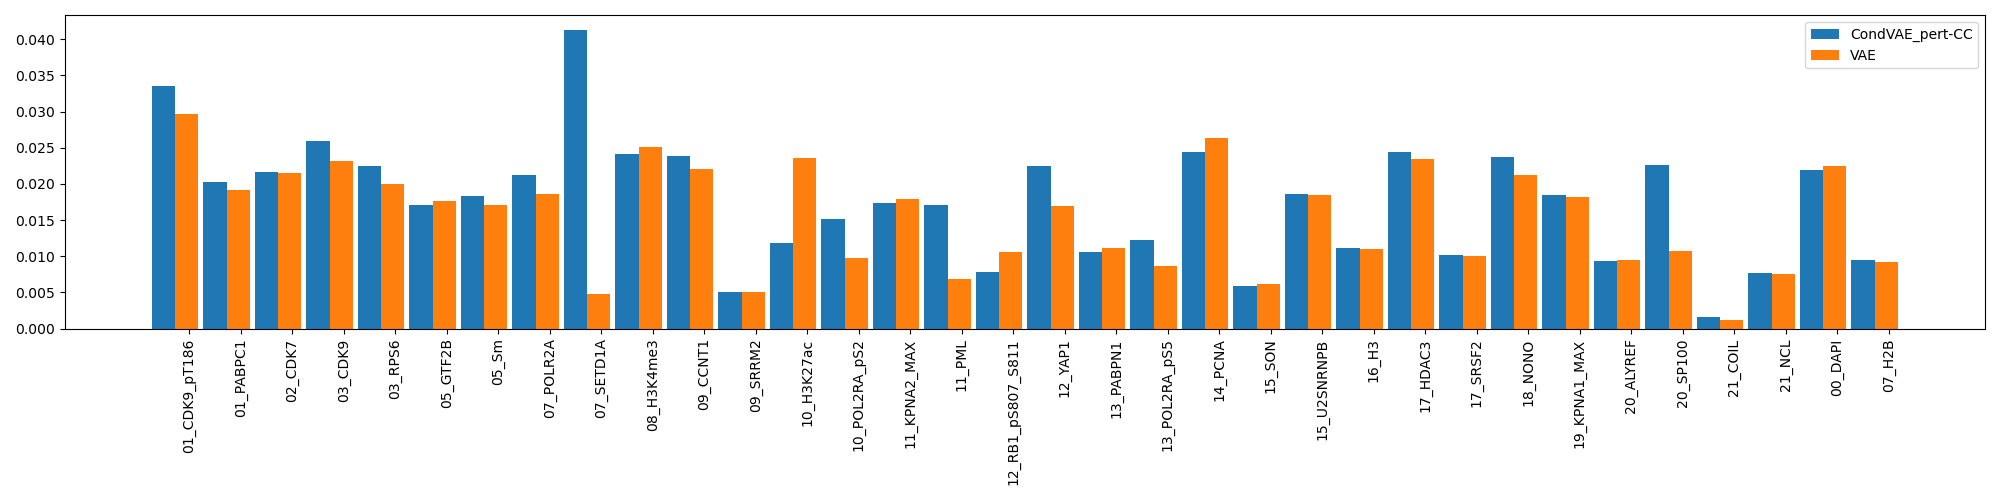

In [81]:
Image(os.path.join(EXPERIMENT_DIR, results_new, '../../../per_channel_mse.png'))

In [14]:
from miann.tl import Experiment, Predictor
import logging
import tensorflow as tf
logging.basicConfig(level=logging.INFO)

In [2]:
exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')

INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC


In [3]:
pred = Predictor(exp)

INFO:Predictor:Creating Predictor for VAE_all/CondVAE_pert-CC
2021-11-12 20:04:11.486106: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:VAEModel:Creating model
INFO:Estimator:Initializing model with weights from /home/icb/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/VAE_all/CondVAE_pert-CC/weights_epoch025
INFO:MPPData:Created new: MPPData for NascentRNA (615240 mpps with shape (3, 3, 34) from 9472 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels', 'conditions'].
INFO:MPPData:Loaded data from /home/icb/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/datasets/184A1_all_frac0005_neigh3_cond_pert-CC/train.
INFO:MPPData:Created new: MPPData for NascentRNA 

In [13]:
pred.est.model.model.layers[5].get_weights()

[array([[[[ 0.03625773, -0.01094775,  0.00401448, ...,  0.03628363,
            0.00567318, -0.01894843],
          [-0.01699647,  0.15237184,  0.21892203, ...,  0.02592902,
            0.02440244, -0.02229135],
          [ 0.08131277, -0.05485538, -0.02972084, ...,  0.03953104,
           -0.01844961, -0.01628068],
          ...,
          [-0.04090471,  0.11540664, -0.0310292 , ..., -0.06741594,
           -0.13069643, -0.13455905],
          [-0.06911104,  0.17981389,  0.07841238, ...,  0.04722184,
           -0.03671534,  0.0281972 ],
          [-0.01587294,  0.04506457, -0.26087132, ...,  0.01032447,
           -0.04216748, -0.1863574 ]]]], dtype=float32),
 array([ 0.21011074,  0.06551113,  0.16365065, -0.02825835,  0.02882265,
        -0.0032464 , -0.03458498,  0.14263816,  0.11924603,  0.1602655 ,
         0.01927989, -0.15669711,  0.0273484 ,  0.07864825,  0.05008699,
         0.06658026, -0.01032866,  0.08269101,  0.14606632,  0.09265687,
         0.21658574, -0.06611693,  0.1

In [37]:
pred.est.model.model.layers[5].get_weights()

[array([[[[ 0.03625773, -0.01094775,  0.00401448, ...,  0.03628363,
            0.00567318, -0.01894843],
          [-0.01699647,  0.15237184,  0.21892203, ...,  0.02592902,
            0.02440244, -0.02229135],
          [ 0.08131277, -0.05485538, -0.02972084, ...,  0.03953104,
           -0.01844961, -0.01628068],
          ...,
          [-0.04090471,  0.11540664, -0.0310292 , ..., -0.06741594,
           -0.13069643, -0.13455905],
          [-0.06911104,  0.17981389,  0.07841238, ...,  0.04722184,
           -0.03671534,  0.0281972 ],
          [-0.01587294,  0.04506457, -0.26087132, ...,  0.01032447,
           -0.04216748, -0.1863574 ]]]], dtype=float32),
 array([ 0.21011074,  0.06551113,  0.16365065, -0.02825835,  0.02882265,
        -0.0032464 , -0.03458498,  0.14263816,  0.11924603,  0.1602655 ,
         0.01927989, -0.15669711,  0.0273484 ,  0.07864825,  0.05008699,
         0.06658026, -0.01032866,  0.08269101,  0.14606632,  0.09265687,
         0.21658574, -0.06611693,  0.1

In [32]:
weights_path = tf.train.latest_checkpoint(exp.full_path)

# first need to compile the model
#self._compile_model()
res = pred.est.model.model.load_weights(weights_path)

In [36]:
res2 = res.assert_nontrivial_match().assert_existing_objects_matched()

In [38]:
tf.__version__

'2.6.0'

In [31]:
import numpy as np
pred.est.model.model.predict((np.zeros((10,3,3,34)), np.zeros((10,14))))

[array([[ 0.00221749,  0.1046002 ,  0.00697981,  0.01401726,  0.09048003,
          0.04273027,  0.00521283, -0.03311826,  0.00620522, -0.02113554,
         -0.0343705 ,  0.03230642, -0.07118195,  0.18686764, -0.08056778,
          0.00379878, -0.0514067 ,  0.00242151,  0.07623607,  0.0686083 ,
         -0.1431078 ,  0.01915559,  0.11919412,  0.06084925, -0.01296067,
         -0.04922262,  0.08345449,  0.00141943,  0.01020838, -0.04004101,
         -0.04605797,  0.05135288,  0.19291548,  0.13456829],
        [-0.00052559,  0.09556897,  0.00519045,  0.01204851,  0.08132713,
          0.04042056,  0.00195102, -0.03518002,  0.00302042, -0.02290528,
         -0.03743526,  0.029484  , -0.07092021,  0.18752445, -0.0862041 ,
          0.00401434, -0.05002326, -0.0017413 ,  0.07456884,  0.06850891,
         -0.14434594,  0.01628213,  0.11521319,  0.05864349, -0.01984525,
         -0.05229543,  0.08403043, -0.00565585,  0.00880851, -0.03932945,
         -0.05085546,  0.05006494,  0.19196089,  0

In [25]:
res2.initialize_or_restore()

In [23]:
pred.est.model.model.load_weights?

Signature:
pred.est.model.model.load_weights(
    filepath,
    by_name=False,
    skip_mismatch=False,
    options=None,
)
Docstring:
Loads all layer weights, either from a TensorFlow or an HDF5 weight file.

If `by_name` is False weights are loaded based on the network's
topology. This means the architecture should be the same as when the weights
were saved.  Note that layers that don't have weights are not taken into
account in the topological ordering, so adding or removing layers is fine as
long as they don't have weights.

If `by_name` is True, weights are loaded into layers only if they share the
same name. This is useful for fine-tuning or transfer-learning models where
some of the layers have changed.

Only topological loading (`by_name=False`) is supported when loading weights
from the TensorFlow format. Note that topological loading differs slightly
between TensorFlow and HDF5 formats for user-defined classes inheriting from
`tf.keras.Model`: HDF5 loads based on a flattened 